# Import

In [4]:
import sys
sys.path.append("..")

from src.data import CrossSimilarityDataset
from src.utils import plot_cross_similarity, load_config
from src.transforms import RandomJumps
from src.dcnn import DCNN

import os
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Resize
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import warnings

warnings.simplefilter('ignore')

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Load dataset


In [7]:
val_dir = "../../dcnn-data/val"

In [8]:
config = load_config("../configs/exp1.yaml")

In [10]:
img_size = config['transforms']['img_size']
fs = config['transforms']['fs']
min_num_jumps = config['transforms']['min_num_jumps']
max_num_jumps = config['transforms']['max_num_jumps']
max_silence_s = config['transforms']['max_silence_s']

In [11]:
transform = Resize((img_size, img_size), antialias=True)
jumps_transform = RandomJumps(fs, min_num_jumps=min_num_jumps, max_num_jumps=max_num_jumps, max_silence_s=max_silence_s)

val_dataset = CrossSimilarityDataset(val_dir,
                                     transform,
                                     structural_transform=jumps_transform,
                                     inference_only=False)

In [12]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Load model

In [13]:
checkpoint_path = "../checkpoints/dcnn_exp1.pt"

In [15]:
hidden_channels = config['model']['hidden_channels']

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
model = DCNN(img_size, hidden_channels, max_num_jumps * 2).to(device)

In [21]:
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

# Inference

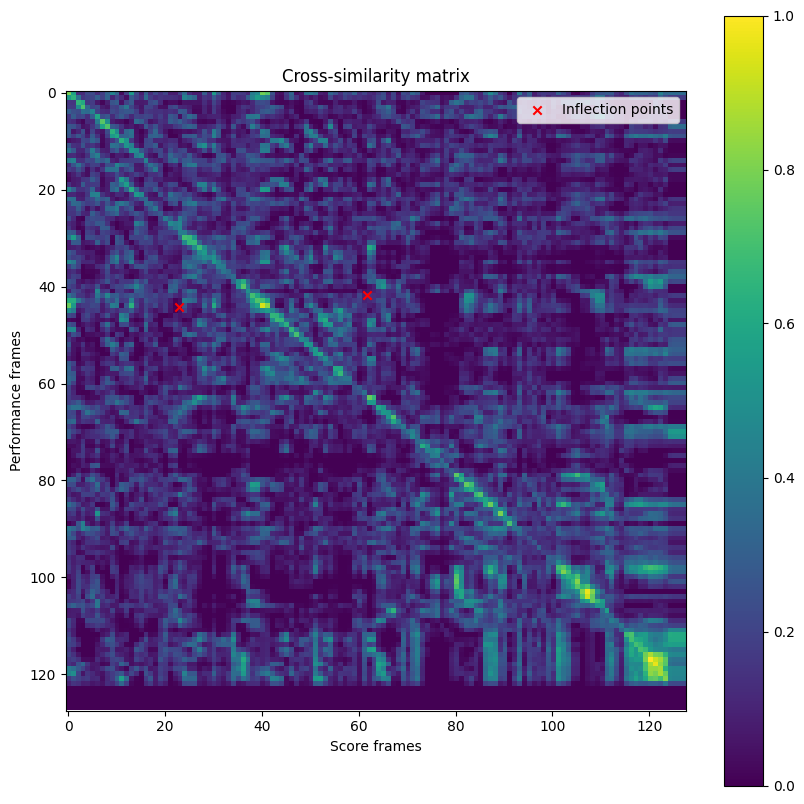

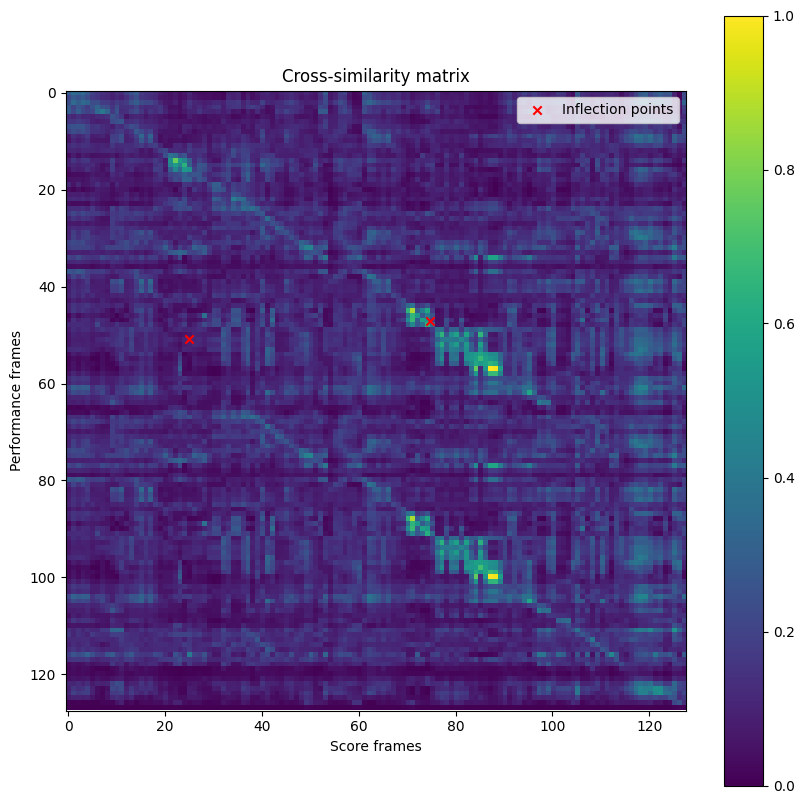

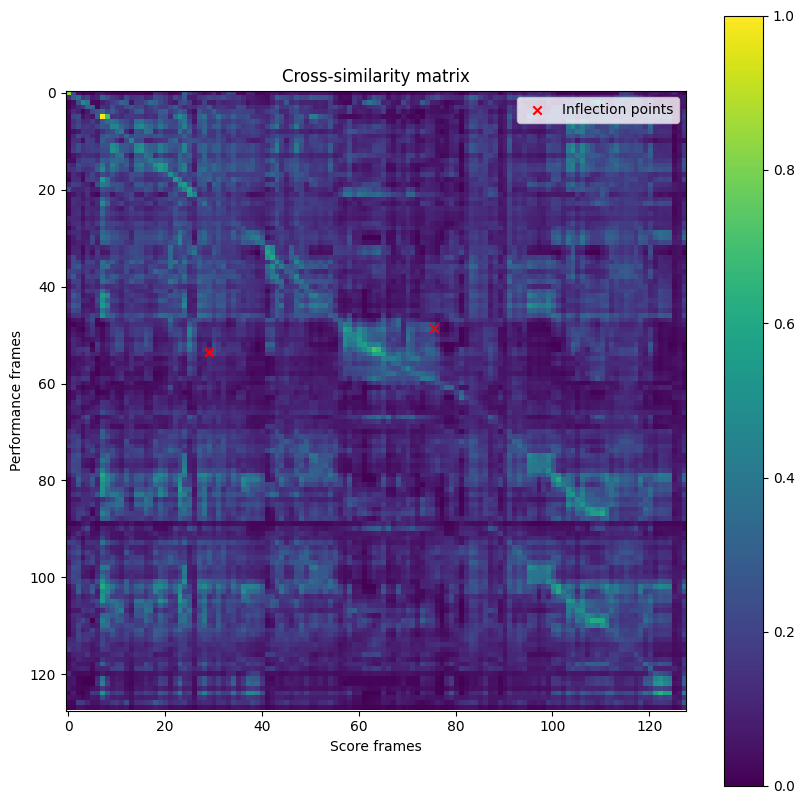

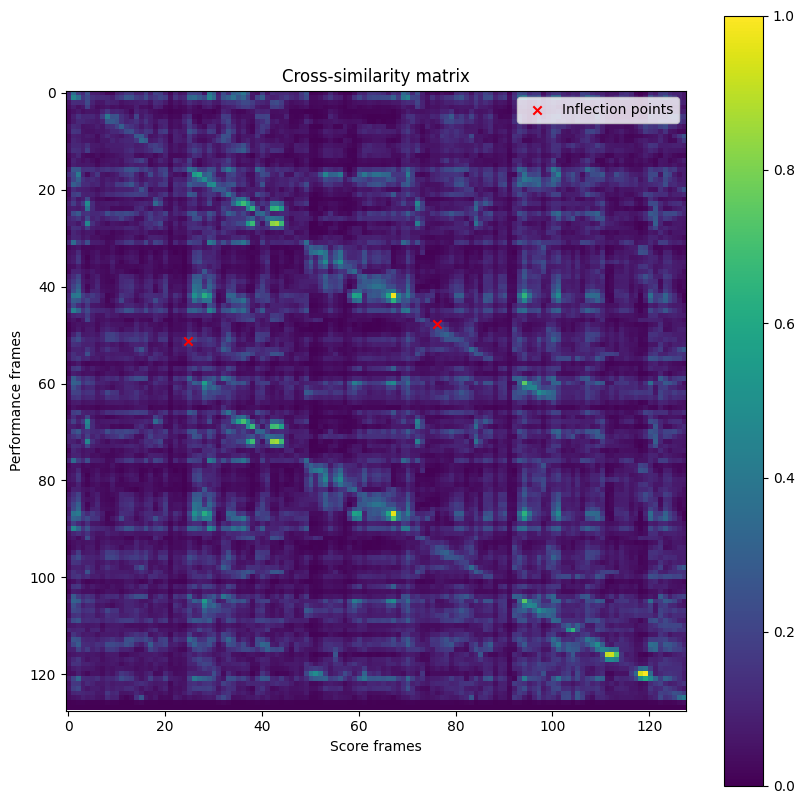

In [24]:
model.eval()
for i, batch in enumerate(val_loader):
    x = batch['image'].to(device)
    y_true = batch['target'].to(device)
    with torch.no_grad():
        y_pred = model(x)

    log_images = x.cpu().numpy()
    log_y_pred = y_pred.cpu().numpy()
    break

bs = len(log_images)
for i in range(min(4, bs)):
    plot_cross_similarity(log_images[i], inflection_points=log_y_pred[i])